In [97]:
# to use R in the notebook
%load_ext rpy2.ipython

import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


# Dimensionality Reduction
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS


# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV

# model evaluation
from sklearn import metrics

# classification
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
data_dir = '../input'

In [3]:
visa = pd.read_csv(f'{data_dir}/VisaPremier.txt', delim_whitespace=True)

## Exploration des données:

Il existe des variables qui représentent la même information sous deux formes (chaîne de caractères / entiers)

- cartevp / cartevpr
- sexe / sexer

Les types de variables sont les suivants:
- Categorielles:
    - matricul: identifiant (inutile pour l'analyse et le classement)
    
    - cartevp/cartevpr: possession de la carte Visa Premier (binaire). variable a predire
    - codeqlt: code de qualite du client evalue par la banque (A - E)
    - csp: categorie socio-professionnelle (8 valeurs)
    - departem: departement de residence
    - sexe/sexer: le sexe du client (binaire)
    - sitfamil: situation familiale (6 valeurs)
    
- Numeriques:
    - age: l'age du client (annees)
    - agemvt: age du dernier mouvement (jours)
    - anciente: anciennete de la relation (mois)
    - aveparfi: total des avoirs epargne financiere (francs)
    - aveparmo: total des avoirs epargne monetaire (francs)
    - avtscpte: total des avoirs sur tous les comptes (francs) --> `avtscpte ?= aveparfi + aveparmo + ...`
    - endette: taux d'endettement (pourcentage)
    - engagemc: Total des engagements court terme (francs)
    - engageml: Engagement long terme
    - engagemm: Total des engagements moyen terme
    - engagemt: Total des engagements (francs) --> `engagemt = engagemc + engagemm + engageml`
    - moycred3: Moyenne des mouvements nets créditeurs des 3 mois (milliers de francs)
    - moycredi: Moyenne des mouvements créditeurs (milliers de francs)
    - moysold3: Moyenne des soldes moyens sur 3 mois
    - mtbon: Montant des produits bons et certificats (francs)
    - mteparlo: Montant des produits d’épargne logement (francs)
    - mteparlt: Montant des produits d’épargne long terme (francs)
    - mteparmo: Montant des produits d’épargne monétaire (francs)
    - mteparte: Nombre de produits épargne à terme
    - mtfactur: Montant facturé dans l’année
    - mtlivret: Montant des comptes sur livret (francs)
    - mtrejet: montant total des rejets (francs)
    - mtvie: Montant des produits contrats vie (francs)
    - nbbon: Nombre de produits bons et certificats
    - nbcb: Nombre total de cartes
    - nbcptar:  Nombre de cartes point argent
    - nbcptvue: Nombre de comptes à vue
    - nbeparlo: Nombre de produits d’épargne logement
    - nbeparlt:  Nombre de produits d’épargne long terme
    - nbeparmo: Nombre de produits épargne monétaire
    - nbeparte: Montant des produits épargne à terme
    - nbimpaye: nombre d'impayés en cours
    - nbjdebit: Nombre de jours de débit
    - nblivret: Nombre de comptes sur livret
    - nbop: Nombre d’opérations à M-1
    - nbopguic: nombre d'opérations par gichets dans le mois
    - nbpaiecb: Nombre de paiements par carte bancaire à M-1
    - nbvie: Nombre de produits contrats vie
    - ptvente: point de vente (nombre de points de vente?)

Les valeurs manquantes qui existent dans les variables sont representees par des '.' (ou F.)

In [4]:
visa.columns

Index(['matricul', 'departem', 'ptvente', 'sexe', 'age', 'sitfamil',
       'anciente', 'csp', 'codeqlt', 'nbimpaye', 'mtrejet', 'nbopguic',
       'moycred3', 'aveparmo', 'endette', 'engagemt', 'engagemc', 'engagemm',
       'nbcptvue', 'moysold3', 'moycredi', 'agemvt', 'nbop', 'mtfactur',
       'engageml', 'nbvie', 'mtvie', 'nbeparmo', 'mteparmo', 'nbeparlo',
       'mteparlo', 'nblivret', 'mtlivret', 'nbeparlt', 'mteparlt', 'nbeparte',
       'mteparte', 'nbbon', 'mtbon', 'nbpaiecb', 'nbcb', 'nbcbptar',
       'avtscpte', 'aveparfi', 'cartevp', 'sexer', 'cartevpr', 'nbjdebit'],
      dtype='object')

In [5]:
quali_vars = ['codeqlt', 'csp', 'departem', 'sexe', 'sitfamil'] # 'cartevpr', 'sexer' 
quanti_vars = ['age', 'agemvt', 'anciente', 'aveparfi', 'aveparmo', 'avtscpte',
               'endette', 'engagemc', 'engageml', 'engagemm', 'engagemt',
               'moycred3', 'moycredi', 'moysold3', 'mtbon', 'mteparlo', 'mteparlt',
               'mteparmo', 'mteparte', 'mtfactur', 'mtlivret', 'mtrejet', 'mtvie',
               'nbbon', 'nbcb', 'nbcbptar', 'nbcptvue', 'nbeparlo', 'nbeparlt',
               'nbeparmo', 'nbeparte', 'nbimpaye', 'nbjdebit', 'nblivret',
               'nbop', 'nbopguic', 'nbpaiecb', 'nbvie', 'ptvente']

In [6]:
visa.shape

(1073, 48)

### Analyse des valeurs manquantes

In [7]:
na_count = visa.isnull().sum()
na_count[na_count != 0]

Series([], dtype: int64)

In [8]:
visa.matricul.unique().shape, visa.shape

(1073,)

In [10]:
dots = ((visa == '.') | (visa == 'F.'))
dot_count = dots.sum()
na_table = pd.DataFrame({
    'NA': dot_count[dot_count != 0],
    'percent_NA': np.round(dot_count[dot_count != 0] / visa.shape[0] * 100, 2)
}, index=dot_count.index[dot_count != 0])
na_table

,NA,percent_NA
departem,7,0.65
sitfamil,32,2.98
codeqlt,133,12.40
agemvt,6,0.56
nbpaiecb,278,25.91


In [11]:
visa[dots] = np.nan
visa.loc[:, quanti_vars] = visa.loc[:, quanti_vars].astype(float)
visa.to_csv('../output/visa.csv', index=False)

In [12]:
visa_quali = visa[quali_vars].copy()
visa_quanti = visa[quanti_vars].copy()

### Analyse univariée

Text(0.5, 1.0, 'cartevp distribution')

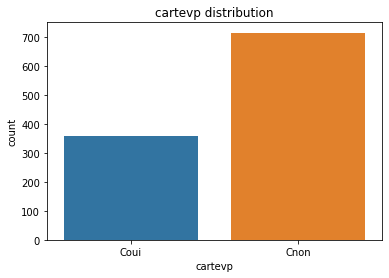

In [13]:
sns.countplot(x=visa.cartevp)
plt.title(f'"cartevp" distribution')

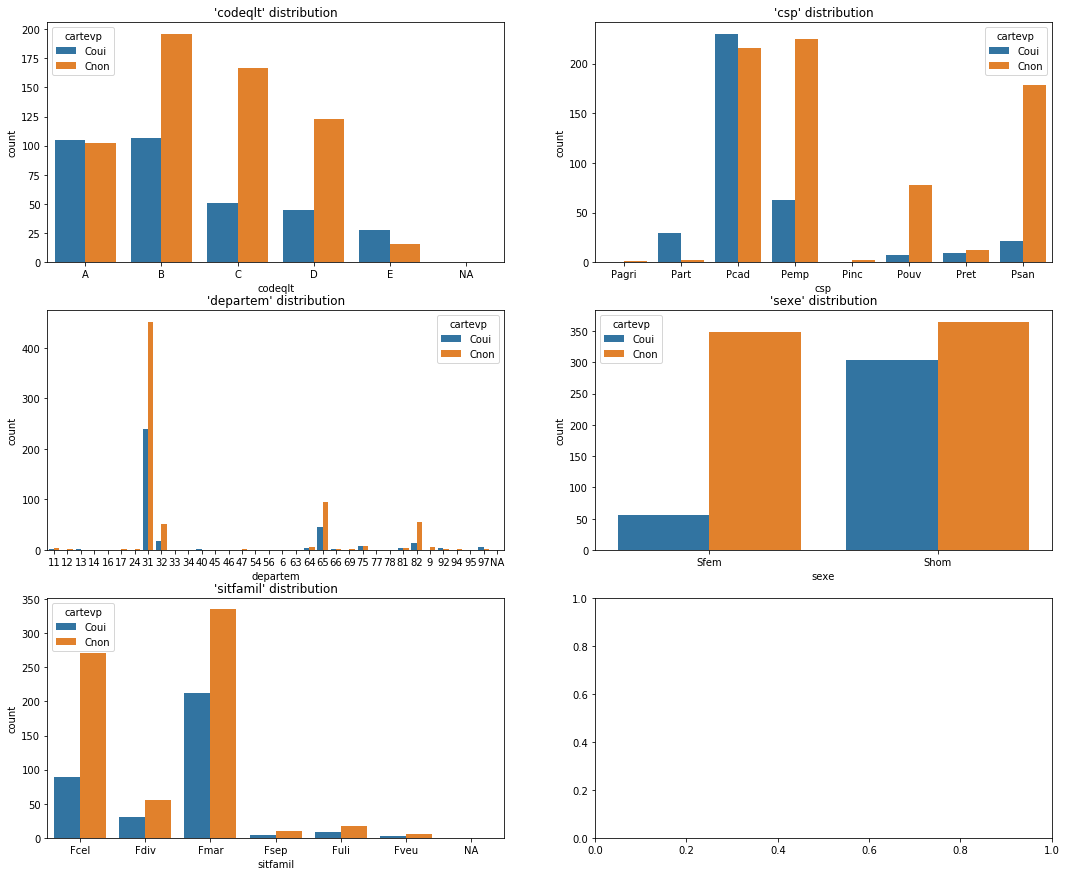

In [14]:
nrow, ncol = 3,2
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

for i in range(visa_quali.shape[1]):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = quali_vars[i]
    
#     visa_quali[var_name].value_counts().sort_index().plot.bar(ax=ax)
    order=np.sort(visa_quali[var_name].fillna('NA').unique())
    sns.countplot(x=visa_quali[var_name], hue=visa.cartevp,
                  order=order, 
                  ax=ax)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title(f'{var_name!r} distribution')

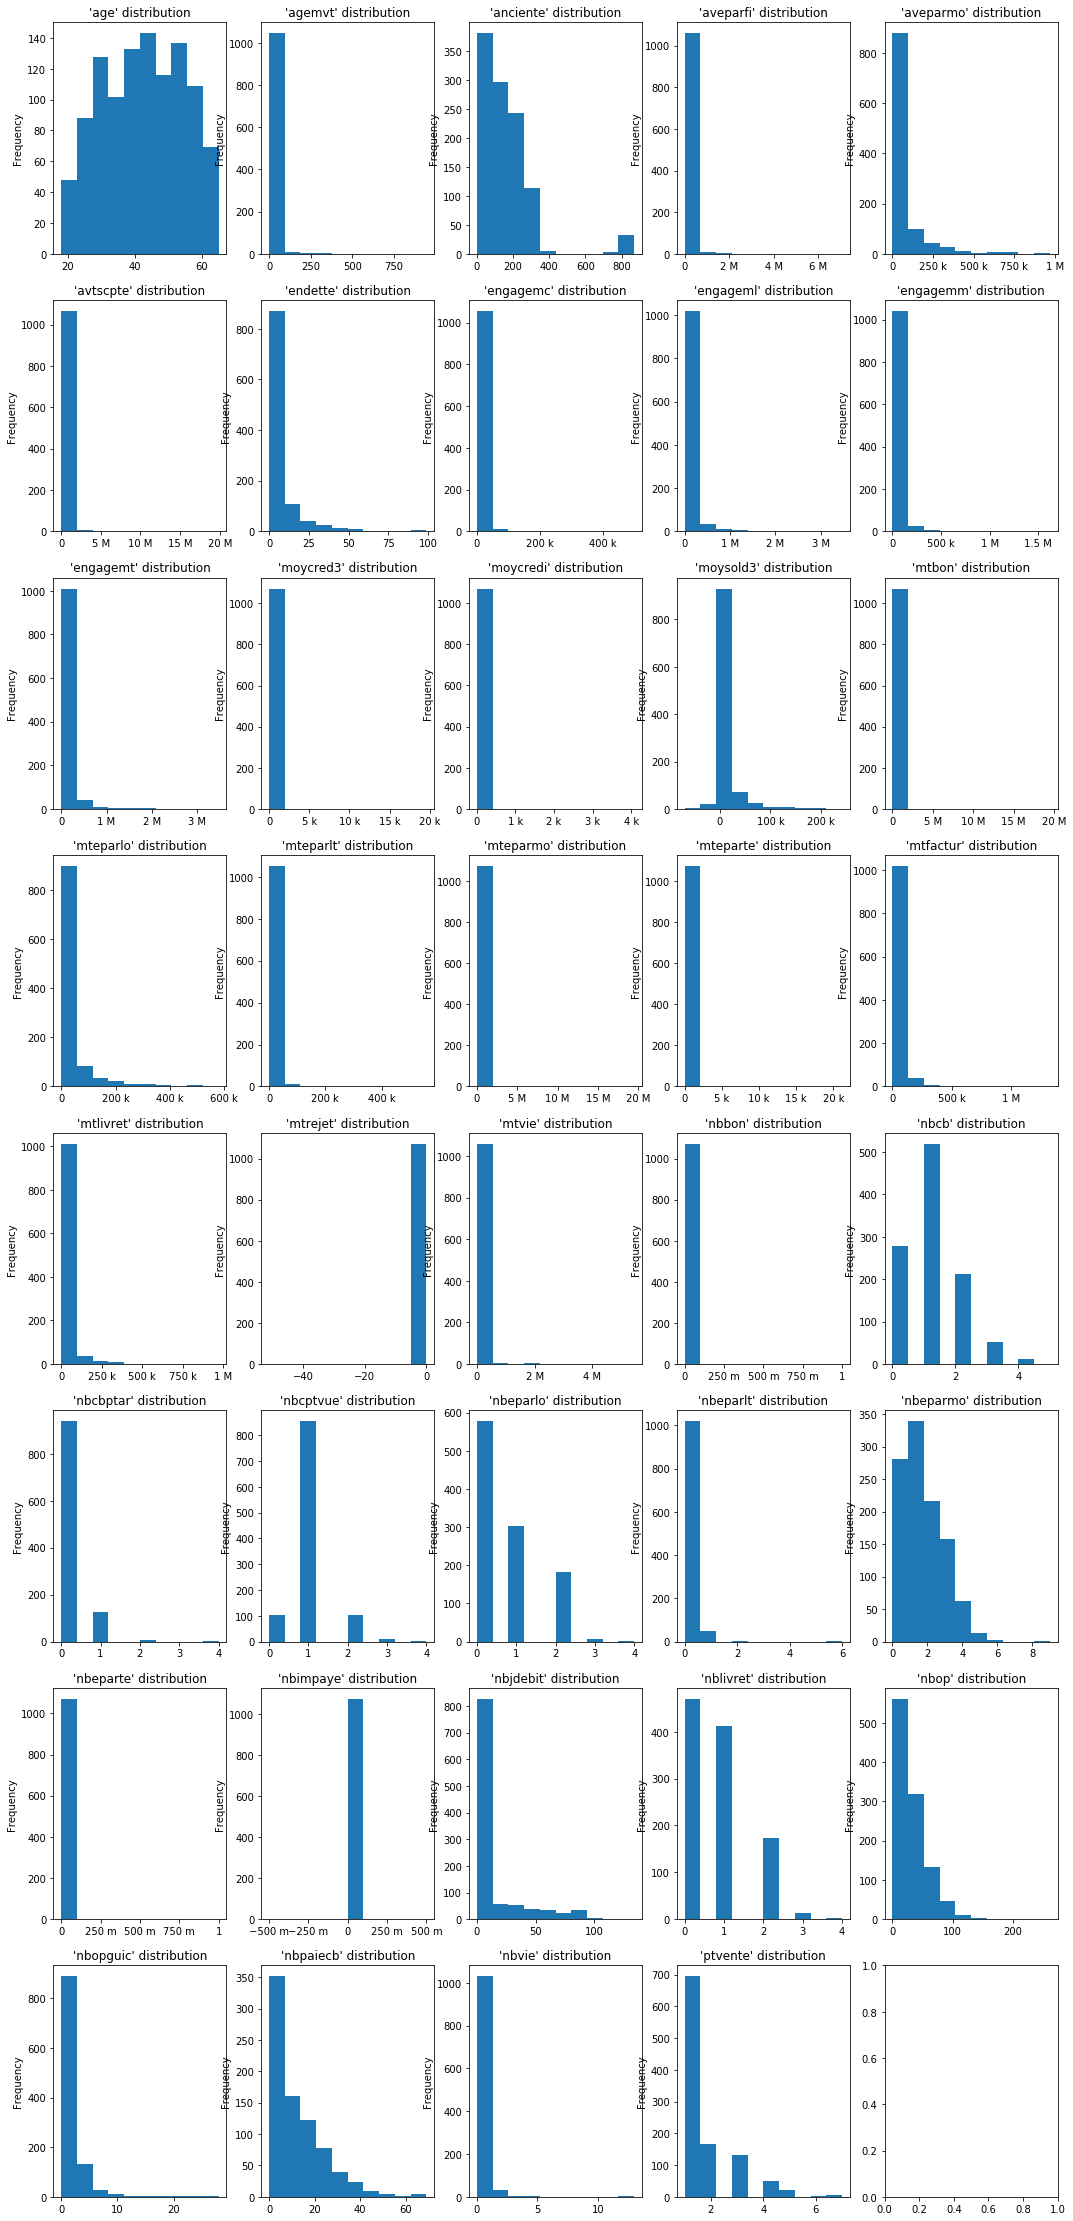

In [14]:
nvars = visa_quanti.shape[1]
ncol = 5
nrow  = nvars // ncol + (1 if nvars%ncol != 0 else 0)
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

for i in range(nvars):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = visa_quanti.columns[i]
    
    s = visa_quanti[var_name]
    s.plot.hist(ax=ax)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title(f'{var_name!r} distribution')

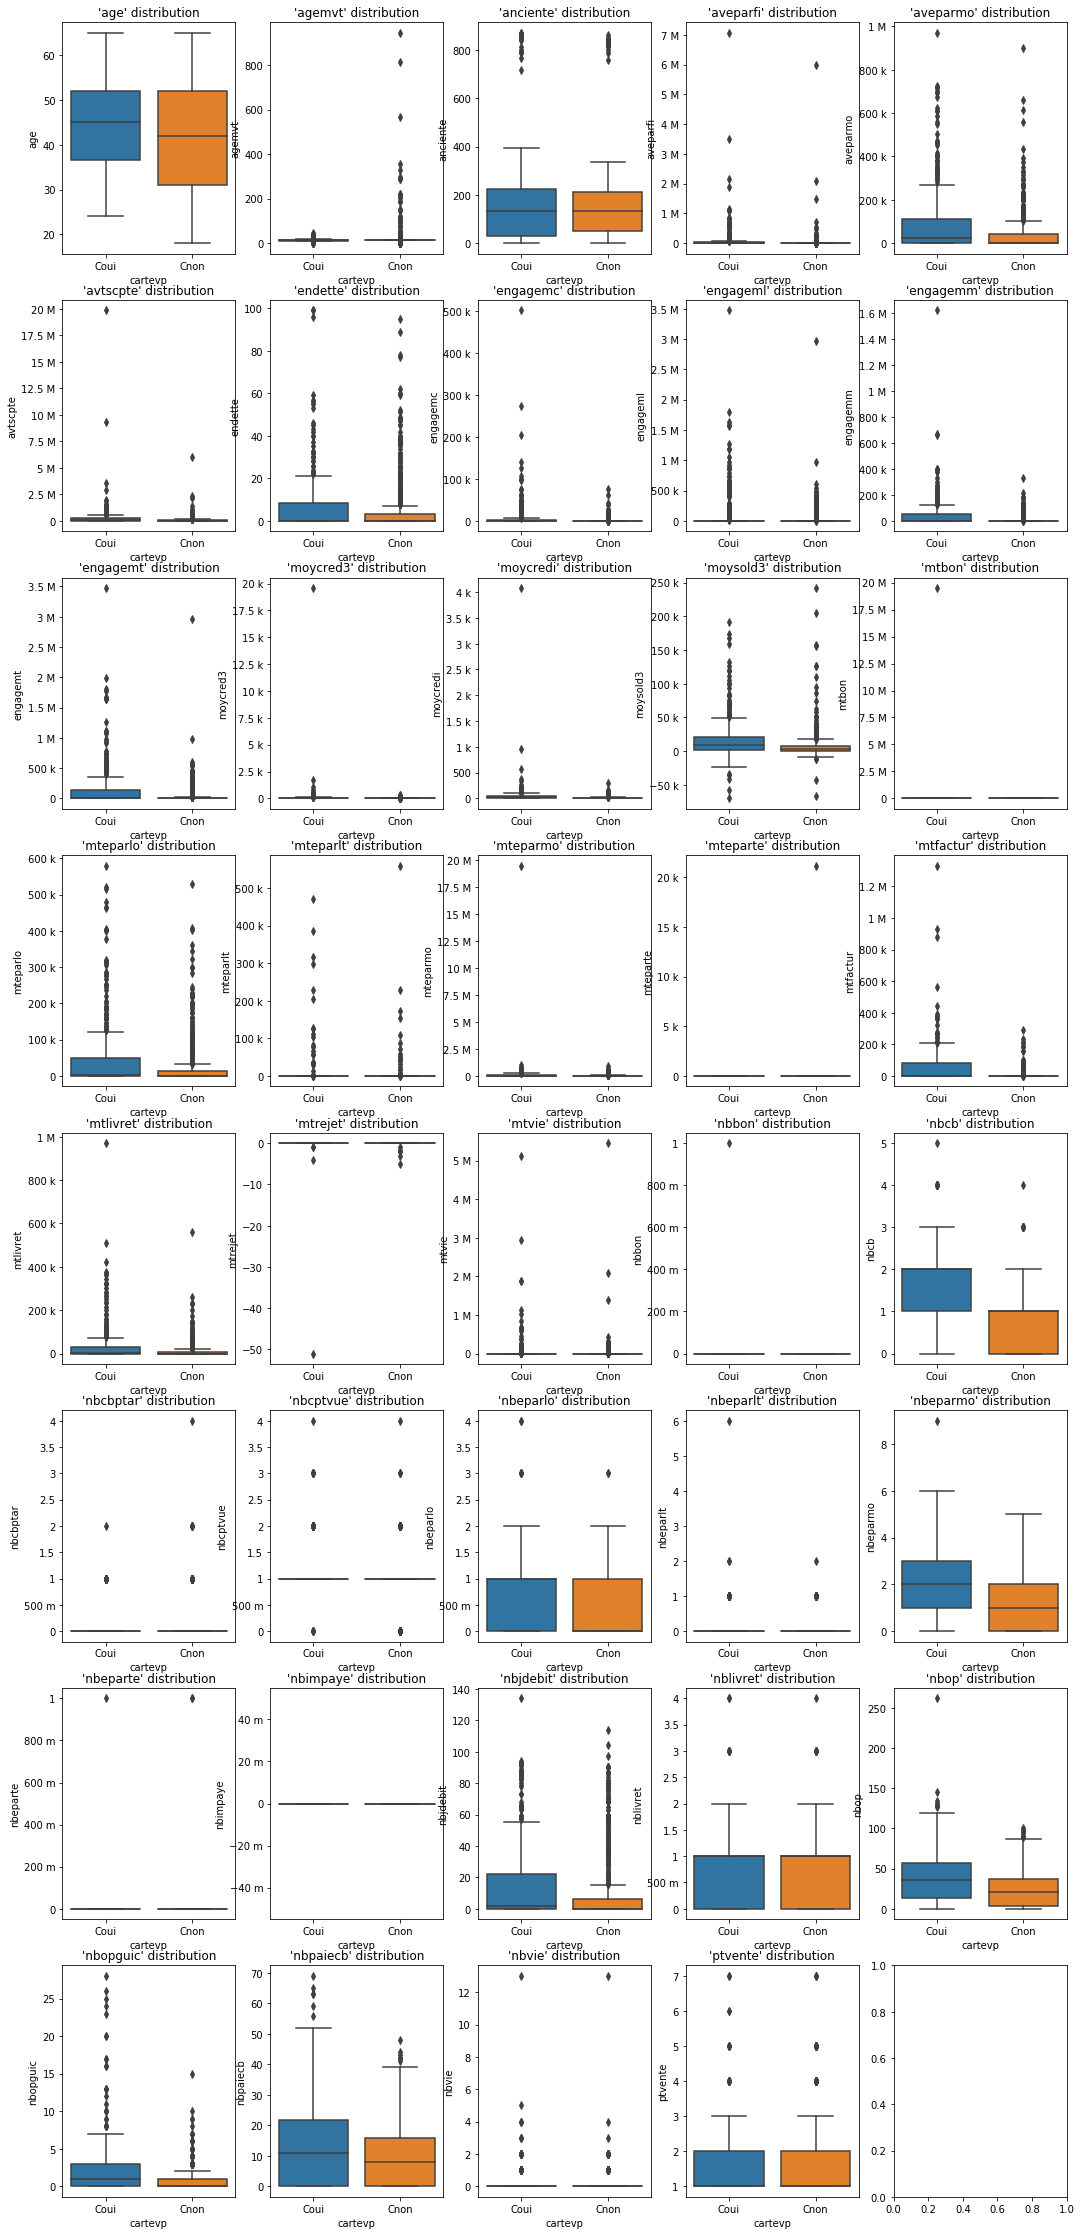

In [15]:
nvars = visa_quanti.shape[1]
ncol = 5
nrow  = nvars // ncol + (1 if nvars%ncol != 0 else 0)
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

for i in range(nvars):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = visa_quanti.columns[i]
    
    s = visa_quanti[var_name]
    sns.boxplot(x=visa.cartevp, y=s, ax=ax)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title(f'{var_name!r} distribution')

In [16]:
visa_log = visa_quanti.drop(columns=['nbcb', 'nbcbptar', 'nbcptvue', 'nbeparlo', 'nbeparlt', 'nbeparte',
                                     'nblivret', 'nbvie', 'ptvente']).copy()
visa_log = visa_log.apply(lambda x: np.log(np.abs(x)+1))

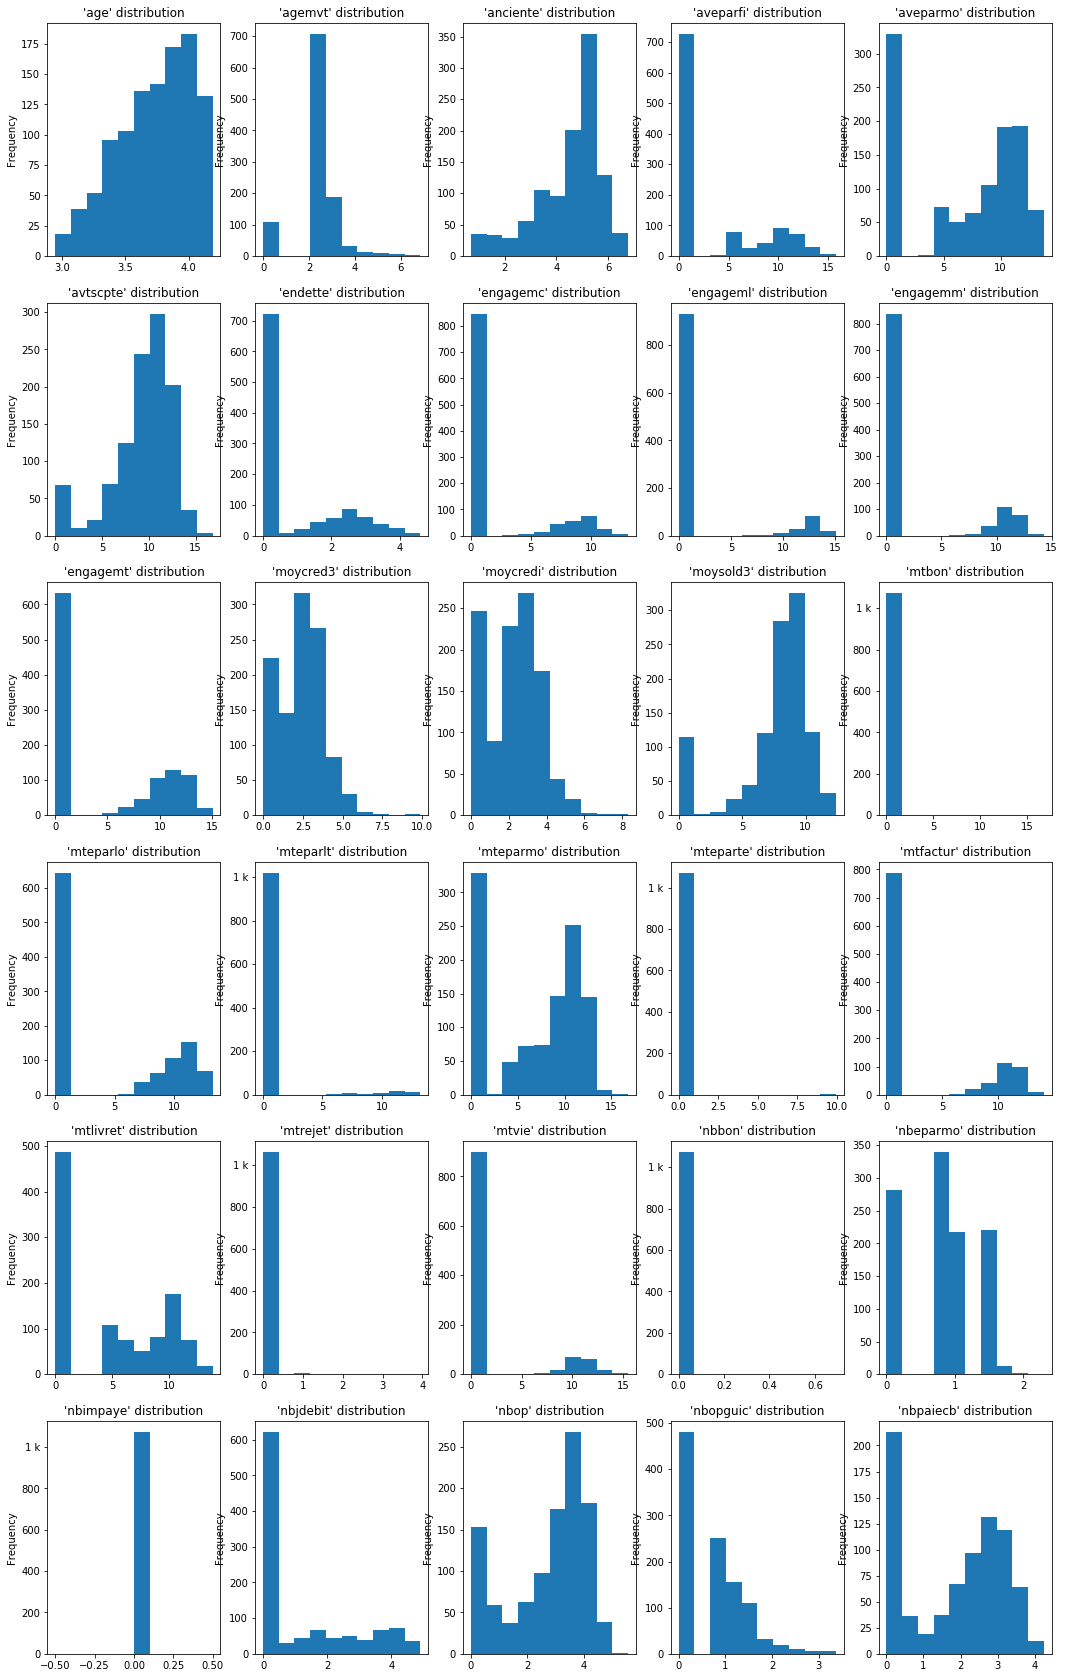

In [17]:
nvars = visa_log.shape[1]
ncol = 5
nrow  = nvars // ncol + (1 if nvars%ncol != 0 else 0)
fig, axs = plt.subplots(nrow, ncol, figsize=(18,5*nrow))

for i in range(nvars):
    row, col = i//ncol, i%ncol
    ax = axs[row, col]
    var_name = visa_log.columns[i]
    
    s = visa_log[var_name]
    s.plot.hist(ax=ax)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title(f'{var_name!r} distribution')

In [18]:
visa.nbimpaye.value_counts()

0.0    1073
Name: nbimpaye, dtype: int64

In [19]:
(visa[['engagemc', 'engagemm', 'engageml']].sum(axis=1).head() != visa.engagemt.head()).sum()

0

#### Suppression des variables inutiles
- On supprime `nbimpaye` parce que sa valeur est constante
- On supprime `engagemt` parce que sa valeur peut être calculée en fonction des variables `engagemc`, `engagemm` et `engageml`

In [20]:
visa = visa.drop(columns=['nbimpaye', 'engagemt'])
visa_quanti = visa_quanti.drop(columns=['nbimpaye', 'engagemt'])

### Remplacement des valeurs manquantes:
Pour les variables numériques, nous utilisons la moyenne.
Pour les variables catégorielles, nous utilisons la modalité modale

In [22]:
new_vals = SimpleImputer().fit_transform(visa_quanti)
visa_quanti_new = pd.DataFrame(new_vals, columns=visa_quanti.columns)

new_vals = SimpleImputer(strategy='most_frequent').fit_transform(visa_quali)
visa_quali_new = pd.DataFrame(new_vals, columns=visa_quali.columns)

### Analyse multivariée

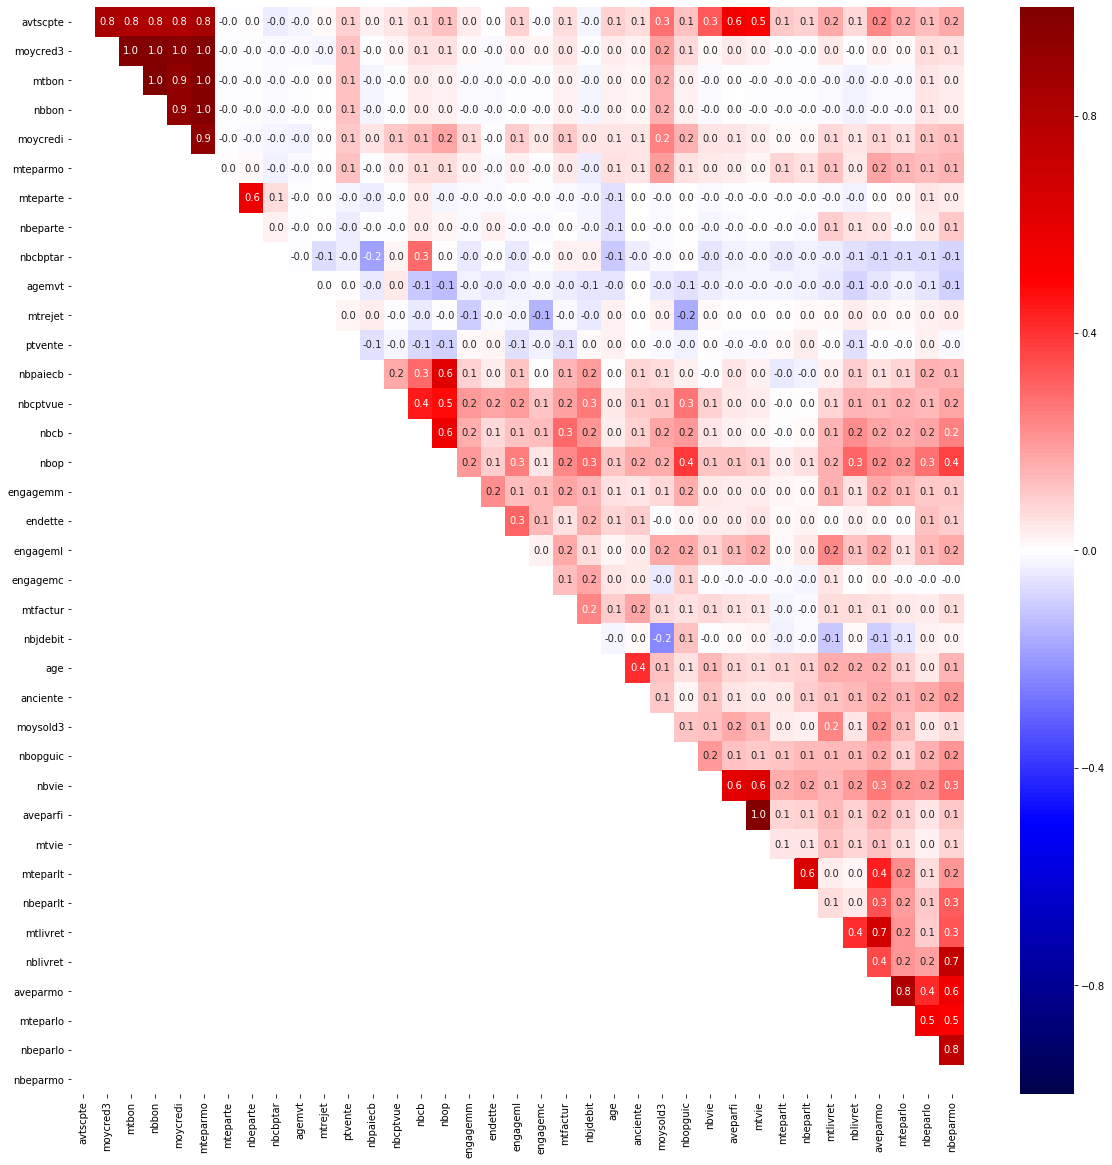

In [24]:
from scipy.cluster import hierarchy
def corplot(df):
    corr = df.corr() # calculate correlations
    d = 2 - 2*corr.values # convert to euclidean distances

    # creation of the dendrogram
    Z = hierarchy.linkage(d, method='ward')
    dn = hierarchy.dendrogram(Z,no_plot=True)
    idx = dn['leaves']
    
    # reorder rows and columns according to the order of the leaves
    cor = corr.copy()
    cor = cor.iloc[:, idx]
    cor = cor.iloc[idx, :]
    
    # delete the values under the diagonal
    idx = np.arange(cor.shape[0])
    mask = idx[:, np.newaxis] < idx
    cor.values[~mask] = np.nan
    

    ax = sns.heatmap(cor, annot=True, fmt='.1f', cmap='seismic', vmin=-1, vmax=1)
    # adjust ticks (problem on windows)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

plt.figure(figsize=(20,20))
corplot(visa_quanti_new)

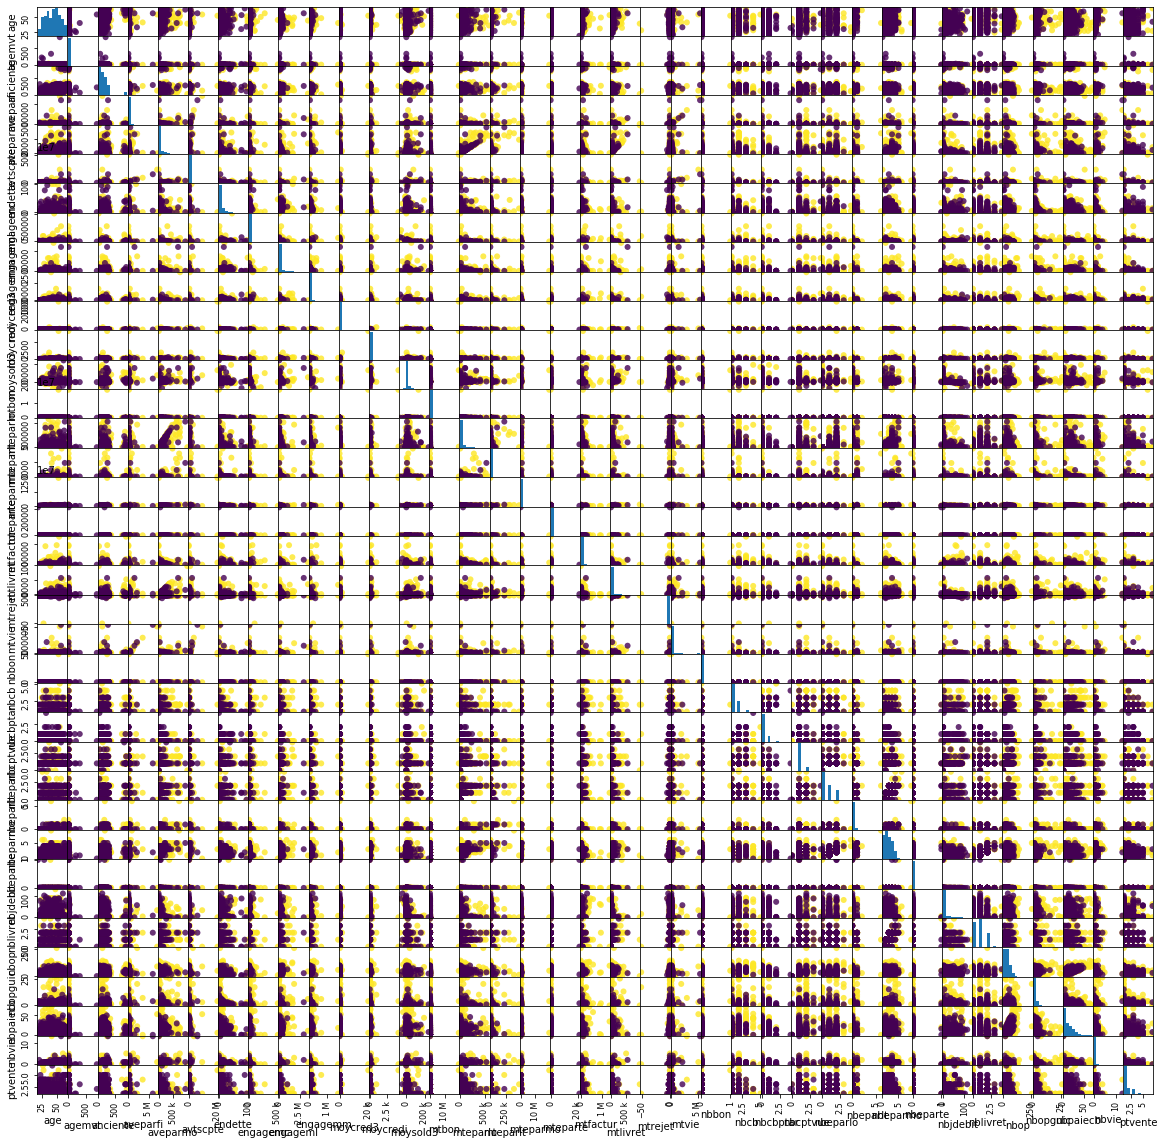

In [119]:
# # Pair plots
# sns.pairplot(visa_quanti.iloc[:,:4], hue=visa.cartevpr)
# axs = pd.plotting.scatter_matrix(visa_quanti.dropna(), #.iloc[:, :4],
#                            c=visa.cartevpr[~visa_quanti.isnull().any(axis=1)],
#                            figsize=(20, 20),
#                            marker='o', alpha=.8)
# for ax in axs.flat:
#     ax.xaxis.set_major_formatter(ticker.EngFormatter())
# #     ax.yaxis.set_major_formatter(ticker.EngFormatter())
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(90)
#     for tick in ax.get_yticklabels():
#         tick.set_rotation(90)

#### Réduction de la dimension

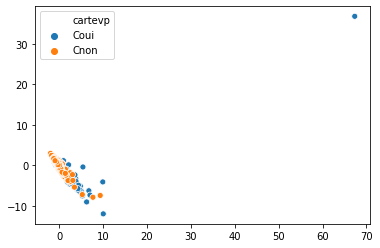

In [25]:
scaled = StandardScaler().fit_transform(visa_quanti_new)
pca_embed = PCA(n_components=2).fit_transform(scaled)
sns.scatterplot(pca_embed[:,0], pca_embed[:,1], hue=visa.cartevp)

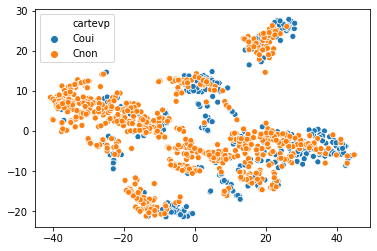

In [26]:
tsne_embed = TSNE(perplexity=50).fit_transform(visa_quanti_new)
sns.scatterplot(tsne_embed[:,0], tsne_embed[:,1], hue=visa.cartevp)

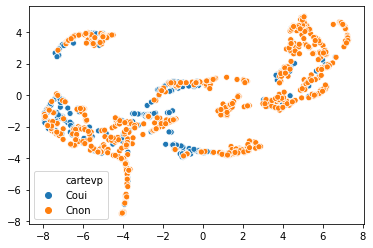

In [27]:
umap_embed = UMAP().fit_transform(visa_quanti_new)
sns.scatterplot(umap_embed[:,0], umap_embed[:,1], hue=visa.cartevp)

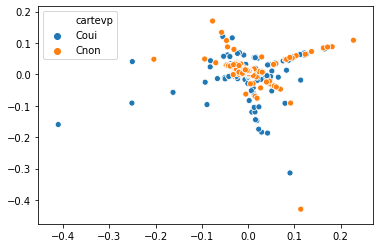

In [28]:
lle_embed = LocallyLinearEmbedding().fit_transform(visa_quanti_new)
sns.scatterplot(lle_embed[:,0], lle_embed[:,1], hue=visa.cartevp)

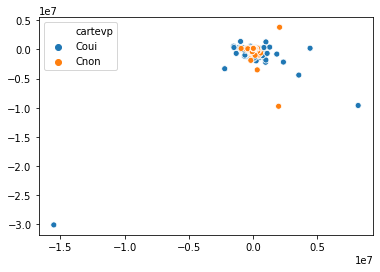

In [29]:
mds_embed = MDS().fit_transform(visa_quanti_new)
sns.scatterplot(mds_embed[:,0], mds_embed[:,1], hue=visa.cartevp)

In [30]:
visa_new = pd.concat([visa_quanti_new, visa_quali_new, visa.cartevp], axis=1)

#### ACP

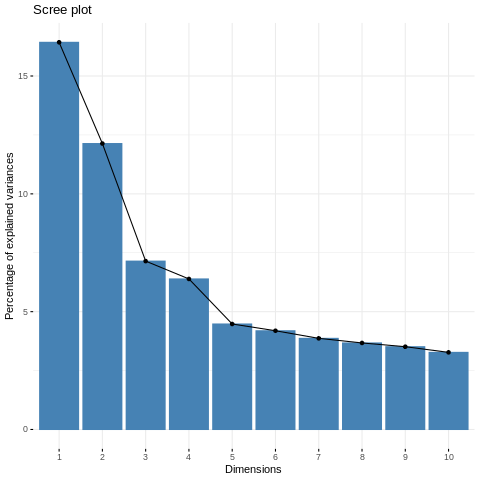

In [33]:
%%R -i visa_quanti_new -i visa_new -o acp
library(FactoMineR)
library(factoextra)
# library(corrplot)

df <- visa_quanti_new

acp <- PCA(df,ncp=ncol(df[-1,]), graph=FALSE) # , ind.sup=c(1,167)
# print(acp$eig[, 2:3])
fviz_screeplot(acp)
# fviz_pca_var(acp,
#              col.var = "cos2",
#              alpha.var = "cos2",
#              gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
#              repel = TRUE
#             )
# # var <- get_pca_var(acp)
# # corrplot(var$contrib, is.corr=FALSE) 
# fviz_contrib(acp, choice = "var", axes = 2, top = 10)
# fviz_pca_ind(acp, col.ind = "cos2", 
#              gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07")
# #              ,
# #              repel = TRUE # Avoid text overlapping (slow if many points)
#              )

#### AFDM

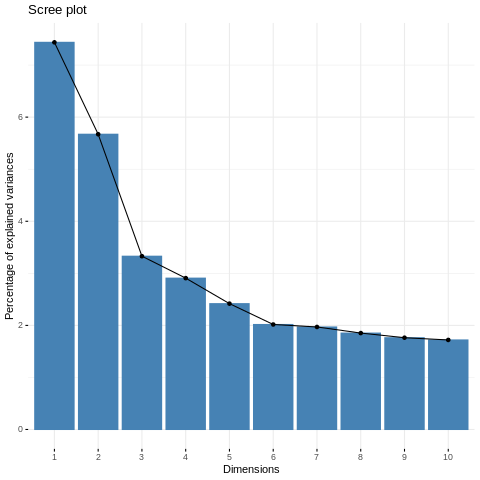

In [34]:
%%R -i visa_new -o afdm
df <- visa_new

library(FactoMineR)
library(tidyverse)
library(factoextra)

n <- nrow(df)
p <- ncol(df)

df[, (p-4):p] <- lapply(df[, (p-4):p], factor)
summary(df[, (p-4):p])

y_idx <- which(colnames(df) == 'cartevp')
afdm <- FAMD(df,ncp=ncol(df), graph=FALSE, sup.var=y_idx)

# eig.val <- get_eigenvalue(afdm)
# print(head(eig.val))
fviz_screeplot(afdm)
# fviz_famd_var(afdm)
# fviz_famd_ind(afdm, habillage='cartevp')

## Classification supervisée

### Préparation des données

###### Method 1: Raw data

In [116]:
enc = OneHotEncoder(sparse=False)
quali_encode = enc.fit_transform(visa_quali_new)
df_visa_raw = pd.concat([visa_quanti_new, pd.DataFrame(quali_encode)], axis=1)

###### Method 2: PCA (quantitative only)

In [117]:
%%R -i acp -o visa_acp
visa_acp <- acp$ind$coord[,1:5]

In [118]:
df_visa_acp = pd.DataFrame(visa_acp)

###### Method 3: AFDM

In [119]:
%%R -i afdm -o visa_afdm
visa_afdm <- afdm$ind$coord[,1:6]

In [120]:
df_visa_afdm = pd.DataFrame(visa_afdm)

###### Method 4: PCA + categorical variables

In [121]:
df_visa_acp_cat = pd.concat([df_visa_acp, pd.DataFrame(quali_encode)], axis=1)

In [122]:
test_size = 0.20
seed = 7

y = visa.cartevpr.values

X_raw = df_visa_raw.values
X_acp = df_visa_acp.values
X_afdm = df_visa_afdm.values
X_acp_cat = df_visa_acp_cat.values

datasets = dict(
    raw = (train_test_split(X_raw, y, test_size=test_size, random_state=seed), False), # use_all_models=False
    acp = (train_test_split(X_acp, y, test_size=test_size, random_state=seed), True),
    afdm = (train_test_split(X_afdm, y, test_size=test_size, random_state=seed), True),
    acp_cat = (train_test_split(X_acp_cat, y, test_size=test_size, random_state=seed), False),
)

### Obtention du meilleur modèle pour chaque algorithme

In [59]:
# Test options and evaluation metric
num_folds = 10
scoring = 'roc_auc'
seed = 420

In [85]:
def train_model(model, name, param_grid, num_folds):
    print(f"Training model {name!r} with score {scoring!r} ...")
    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

    grid.fit(X_train, Y_train)

    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    print()
    
    return grid

def get_cv_score(model, name, num_folds):
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    msg = f"{name}: {cv_results.mean():.4f} ({cv_results.std():.5f})"
    print(msg)
    return cv_results

In [113]:
def make_models(use_all=True):
    lr_params = dict(LR__C=[0.1, .5, .8, 1., 1.5, 2, 3])
    knn_params = dict(KNN__n_neighbors=range(7, 36, 2), KNN__leaf_size=range(5, 20))
    cart_params = dict(CART__min_samples_split=range(2, 15))
    c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
    lsvm_params = dict(SVM__C=c_values)
    kernel_values = ['poly', 'rbf', 'sigmoid']
    svm_params = dict(SVM__C=c_values, SVM__kernel=kernel_values)
    n_estimators = range(30, 111, 5)
    rf_params = dict(RF__n_estimators=n_estimators)
    ada_params = dict(AB__n_estimators=n_estimators)
    gb_params = dict(GB__n_estimators=n_estimators)
    et_params = dict(ET__n_estimators=n_estimators)
    
    if use_all:
        return [
            ('NB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())]), None),
            ('LDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())]), None),
            ('QDA', Pipeline([('Scaler', StandardScaler()),('QDA', QuadraticDiscriminantAnalysis())]), None),
            ('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(solver='lbfgs'))]), lr_params),
            ('KNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())]), knn_params),
            ('CART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())]), cart_params),
            ('LinearSVM', Pipeline([('Scaler', StandardScaler()),('SVM', LinearSVC())]), lsvm_params),
            ('KernelSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC(gamma='auto'))]), svm_params),
            ('RF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())]), rf_params),
            ('AB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostClassifier())]), ada_params),
            ('GB', Pipeline([('Scaler', StandardScaler()),('GB', GradientBoostingClassifier())]), gb_params),
            ('ET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesClassifier())]), et_params),
        ]
    else:
        return [
            ('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(solver='lbfgs'))]), lr_params),
            ('CART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())]), cart_params),
            ('RF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())]), rf_params),
            ('AB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostClassifier())]), ada_params),
            ('GB', Pipeline([('Scaler', StandardScaler()),('GB', GradientBoostingClassifier())]), gb_params),
            ('ET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesClassifier())]), et_params),
        ]

def train_models(models, X_train, y_train, data_name):
    print(f'Training the models using the data {data_name!r}')
    trained_models = [None] * len(models)
    for i, (name, clf, cv_params) in enumerate(models):
        if cv_params is None:
            trained_models[i] = clf.fit(X_train, y_train)
        else:
            grid_result = train_model(clf, name, cv_params, num_folds)
            trained_models[i] = grid_result.best_estimator_
    print('Training complete')
    return trained_models

def score_models(models, X_train, y_train, scorings, data_name):
    pass

In [125]:
data_name = 'raw'
(X_train, _, y_train, _), use_all_models = datasets[data_name] 

models = make_models(use_all=True)
trained_raw = train_models(models, X_train, y_train, data_name)

Training the models using the data 'raw'
Training model 'LR' with score 'roc_auc' ...


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Best: 0.907388 using {'LR__C': 0.5}

Training model 'KNN' with score 'roc_auc' ...
Best: 0.872617 using {'KNN__leaf_size': 5, 'KNN__n_neighbors': 35}

Training model 'CART' with score 'roc_auc' ...
Best: 0.870985 using {'CART__min_samples_split': 11}

Training model 'LinearSVM' with score 'roc_auc' ...


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.914126 using {'SVM__C': 0.1}

Training model 'KernelSVM' with score 'roc_auc' ...
Best: 0.917826 using {'SVM__C': 0.9, 'SVM__kernel': 'sigmoid'}

Training model 'RF' with score 'roc_auc' ...
Best: 0.949033 using {'RF__n_estimators': 110}

Training model 'AB' with score 'roc_auc' ...
Best: 0.957124 using {'AB__n_estimators': 50}

Training model 'GB' with score 'roc_auc' ...
Best: 0.966837 using {'GB__n_estimators': 110}

Training model 'ET' with score 'roc_auc' ...
Best: 0.930735 using {'ET__n_estimators': 55}

Training complete


In [126]:
data_name = 'acp'
(X_train, _, y_train, _), use_all_models = datasets[data_name] 

models = make_models(use_all=True)
trained_acp = train_models(models, X_train, y_train, data_name)

Training the models using the data 'acp'
Training model 'LR' with score 'roc_auc' ...
Best: 0.798778 using {'LR__C': 3}

Training model 'KNN' with score 'roc_auc' ...
Best: 0.779313 using {'KNN__leaf_size': 5, 'KNN__n_neighbors': 35}

Training model 'CART' with score 'roc_auc' ...
Best: 0.711074 using {'CART__min_samples_split': 14}

Training model 'LinearSVM' with score 'roc_auc' ...


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.803962 using {'SVM__C': 2.0}

Training model 'KernelSVM' with score 'roc_auc' ...
Best: 0.781689 using {'SVM__C': 2.0, 'SVM__kernel': 'rbf'}

Training model 'RF' with score 'roc_auc' ...
Best: 0.805857 using {'RF__n_estimators': 35}

Training model 'AB' with score 'roc_auc' ...
Best: 0.788852 using {'AB__n_estimators': 35}

Training model 'GB' with score 'roc_auc' ...
Best: 0.809610 using {'GB__n_estimators': 35}

Training model 'ET' with score 'roc_auc' ...
Best: 0.801009 using {'ET__n_estimators': 80}

Training complete


In [127]:
data_name = 'afdm'
(X_train, _, y_train, _), use_all_models = datasets[data_name] 

models = make_models(use_all=True)
trained_afdm = train_models(models, X_train, y_train, data_name)

Training the models using the data 'afdm'
Training model 'LR' with score 'roc_auc' ...
Best: 0.838853 using {'LR__C': 3}

Training model 'KNN' with score 'roc_auc' ...
Best: 0.828358 using {'KNN__leaf_size': 5, 'KNN__n_neighbors': 29}

Training model 'CART' with score 'roc_auc' ...
Best: 0.736666 using {'CART__min_samples_split': 13}

Training model 'LinearSVM' with score 'roc_auc' ...


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.839171 using {'SVM__C': 1.3}

Training model 'KernelSVM' with score 'roc_auc' ...
Best: 0.829221 using {'SVM__C': 1.3, 'SVM__kernel': 'rbf'}

Training model 'RF' with score 'roc_auc' ...
Best: 0.826120 using {'RF__n_estimators': 65}

Training model 'AB' with score 'roc_auc' ...
Best: 0.808898 using {'AB__n_estimators': 30}

Training model 'GB' with score 'roc_auc' ...
Best: 0.821773 using {'GB__n_estimators': 30}

Training model 'ET' with score 'roc_auc' ...
Best: 0.832164 using {'ET__n_estimators': 90}

Training complete


In [ ]:
data_name = 'acp_cat'
(X_train, _, y_train, _), use_all_models = datasets[data_name] 

models = make_models(use_all=True)
trained_acp_cat = train_models(models, X_train, y_train, data_name)

In [62]:
nb_pipe = Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])
nb_model = nb_pipe.fit(X_train, Y_train)
res = get_cv_score(nb_model, 'scaled GaussianNB', num_folds)

scaled GaussianNB: 0.7689 (0.05840)


In [63]:
lda_pipe = Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])
lda_model = lda_pipe.fit(X_train, Y_train)
res = get_cv_score(lda_model, 'scaled LDA', num_folds)

scaled LDA: 0.8261 (0.05154)


In [64]:
qda_pipe = Pipeline([('Scaler', StandardScaler()),('QDA', QuadraticDiscriminantAnalysis())])
qda_model = qda_pipe.fit(X_train, Y_train)
res = get_cv_score(qda_model, 'scaled QDA', num_folds)

scaled QDA: 0.8084 (0.04446)


In [65]:
lr_pipe = Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(solver='lbfgs'))])
param_grid = dict(LR__C=[0.1, .5, .8, 1., 1.5, 2, 3])
lr_grid = train_model(lr_pipe, 'scaled linear regression', param_grid, num_folds)
lr_model = lr_grid.best_estimator_

Training model 'scaled linear regression' with score 'roc_auc' ...
Best: 0.838853 using {'LR__C': 3}


In [66]:
knn_pipe = Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])
param_grid = dict(KNN__n_neighbors=range(7, 36, 2), KNN__leaf_size=range(5, 20))
knn_grid = train_model(knn_pipe, 'scaled KNN', param_grid, num_folds)
knn_model = knn_grid.best_estimator_

Training model 'scaled KNN' with score 'roc_auc' ...
Best: 0.828358 using {'KNN__leaf_size': 5, 'KNN__n_neighbors': 29}


In [67]:
cart_pipe = Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])
param_grid = dict(CART__min_samples_split=range(2, 15))
cart_grid = train_model(cart_pipe, 'scaled CART', param_grid, num_folds)
cart_model = cart_grid.best_estimator_

Training model 'scaled CART' with score 'roc_auc' ...
Best: 0.733129 using {'CART__min_samples_split': 13}


In [68]:
lsvm_pipe = Pipeline([('Scaler', StandardScaler()),('SVM', LinearSVC())])
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
param_grid = dict(SVM__C=c_values)
lsvm_grid = train_model(lsvm_pipe, 'scaled LinearSVM', param_grid, num_folds)
lsvm_model = lsvm_grid.best_estimator_

Training model 'scaled LinearSVM' with score 'roc_auc' ...


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.839099 using {'SVM__C': 2.0}


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [69]:
svm_pipe = Pipeline([('Scaler', StandardScaler()),('SVM', SVC(gamma='auto'))])
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['poly', 'rbf', 'sigmoid']
param_grid = dict(SVM__C=c_values, SVM__kernel=kernel_values)
svm_grid = train_model(svm_pipe, 'scaled SVM', param_grid, num_folds)
svm_model = svm_grid.best_estimator_

Training model 'scaled SVM' with score 'roc_auc' ...
Best: 0.829221 using {'SVM__C': 1.3, 'SVM__kernel': 'rbf'}


In [70]:
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()

#### Methodes ensemblistes 

In [71]:
rf_pipe = Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])
n_estimators = range(30, 111, 5)
param_grid = dict(RF__n_estimators=n_estimators)
rf_grid = train_model(rf_pipe, 'scaled RF', param_grid, num_folds)
rf_model = rf_grid.best_estimator_

Training model 'scaled RF' with score 'roc_auc' ...
Best: 0.820412 using {'RF__n_estimators': 110}


In [72]:
ada_pipe = Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostClassifier())])
n_estimators = range(30, 111, 5)
param_grid = dict(AB__n_estimators=n_estimators)
ada_grid = train_model(ada_pipe, 'scaled AdaBoost', param_grid, num_folds)
ada_model = ada_grid.best_estimator_

Training model 'scaled AdaBoost' with score 'roc_auc' ...
Best: 0.808898 using {'AB__n_estimators': 30}


In [73]:
gb_pipe = Pipeline([('Scaler', StandardScaler()),('GB', GradientBoostingClassifier())])
n_estimators = range(30, 111, 5)
param_grid = dict(GB__n_estimators=n_estimators)
gb_grid = train_model(gb_pipe, 'scaled GB', param_grid, num_folds)
gb_model = gb_grid.best_estimator_

Training model 'scaled GB' with score 'roc_auc' ...
Best: 0.821046 using {'GB__n_estimators': 30}


In [74]:
et_pipe = Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesClassifier())])
n_estimators = range(30, 111, 5)
param_grid = dict(ET__n_estimators=n_estimators)
et_grid = train_model(et_pipe, 'scaled ET', param_grid, num_folds)
et_model = et_grid.best_estimator_

Training model 'scaled ET' with score 'roc_auc' ...
Best: 0.831167 using {'ET__n_estimators': 85}


In [75]:
estimators = [
    ('NB', nb_model),
    ('LDA', lda_model),
    ('QDA', qda_model),
    ('LR', lr_model),
    ('KNN', knn_model),
    ('CART', cart_model),
    ('LinearSVM', lsvm_model),
    ('KernelSVM', svm_model),
    ('RF', rf_model),
    ('AB', ada_model),
    ('GB', gb_model),
    ('ET', et_model),
]

for name, model in estimators:
    get_cv_score(model, name, num_folds)
    

NB: 0.7689 (0.05840)
LDA: 0.8261 (0.05154)
QDA: 0.8084 (0.04446)
LR: 0.8389 (0.04035)
KNN: 0.8284 (0.05228)
CART: 0.7281 (0.04079)


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number o

LinearSVM: 0.8389 (0.04104)
KernelSVM: 0.8292 (0.04952)
RF: 0.8139 (0.04043)
AB: 0.8089 (0.04202)
GB: 0.8213 (0.04557)
ET: 0.8250 (0.03363)


### Best model

In [ ]:
best = lr_model
# test the model on the test data
# display results with different metrics